# 一、导入数据

In [1]:
import pandas as pd

data = pd.DataFrame([])
for i in range(1,9):
    path = r'./bj_danke_'+str(i)+'.csv'
    data = pd.concat([data,pd.read_csv(path)],axis=0) 
# print(data.shape)
data.head()

(7697, 9)


,价格,面积,编号,户型,楼层,位置1,位置2,小区,地铁
0,1330.0,9.0,38738-A,3室1卫,9/11层,房山区,良乡大学城西,紫汇家园,地铁：距房山线良乡大学城西站550米
1,5810.0,39.0,64752-A,1室1卫,9/12层,东城区,广渠门内,绿景苑,地铁：距7号线广渠门内站650米
2,4820.0,36.0,65359-A,1室1卫,1/6层,东城区,景泰,定安里,地铁：距14号线东段景泰站450米
3,1850.0,9.0,185-B,4室2卫,2/27层,朝阳区,管庄,京通苑阳光华苑,地铁：距八通线管庄站500米
4,9000.0,116.0,17830-A,2室1卫,8/16层,朝阳区,十里堡,天天朝阳,地铁：距6号线十里堡站850米


# 二、数据预处理

In [2]:
import re

#2.1 删除属性为空的行
data = data.dropna(axis=0, how='any')
# print(data.shape)

#2.2 以‘编号’为行索引，故编号唯一，需要删除重复值
data = data.drop_duplicates(subset = ['编号'])
# print(data.shape)
data.set_index('编号',inplace=True)
 
#2.3 新增一列‘小区与地铁站的距离’
data.loc[:,'小区与地铁站的距离'] = data['地铁'].apply(lambda x : int(re.search('(\d{1,})米',x)[1]) if re.search('(\d{1,})米',x) else None)

#2.4 新增一列‘楼的总层数’
data.loc[:,'楼的总层数'] = data['楼层'].apply(lambda x : int(re.search('(\d{1,})/(\d{1,})层',x)[2]) if re.search('(\d{1,})/(\d{1,})层',x) else None)

#2.5 新增一列‘所在楼层’
data.loc[:,'所在楼层'] = data['楼层'].apply(lambda x : int(re.search('(\d{1,})/(\d{1,})层',x)[1]) if re.search('(\d{1,})/(\d{1,})层',x)else None)

#2.6 删除属性值为空的行
data = data.dropna(axis = 0 ,how = 'any')
# print(data.shape)

#2.7 新增一列‘房子每平方的价格’
data['价格'] = data['价格'].astype('f8')
data['面积'] = data['面积'].astype('f8')
data.loc[:,'房子每平方的价格'] = data['价格']/data['面积']

data.head()

,价格,面积,户型,楼层,位置1,位置2,小区,地铁,小区与地铁站的距离,楼的总层数,所在楼层,房子每平方的价格
编号,,,,,,,,,,,,
38738-A,1330.0,9.0,3室1卫,9/11层,房山区,良乡大学城西,紫汇家园,地铁：距房山线良乡大学城西站550米,550.0,11.0,9.0,147.777778
64752-A,5810.0,39.0,1室1卫,9/12层,东城区,广渠门内,绿景苑,地铁：距7号线广渠门内站650米,650.0,12.0,9.0,148.974359
65359-A,4820.0,36.0,1室1卫,1/6层,东城区,景泰,定安里,地铁：距14号线东段景泰站450米,450.0,6.0,1.0,133.888889
185-B,1850.0,9.0,4室2卫,2/27层,朝阳区,管庄,京通苑阳光华苑,地铁：距八通线管庄站500米,500.0,27.0,2.0,205.555556
17830-A,9000.0,116.0,2室1卫,8/16层,朝阳区,十里堡,天天朝阳,地铁：距6号线十里堡站850米,850.0,16.0,8.0,77.586207


# 三、数据分析

## 3.1 小区总体分析

### 3.1.1 各区租房每平米的平均价格比较分析 

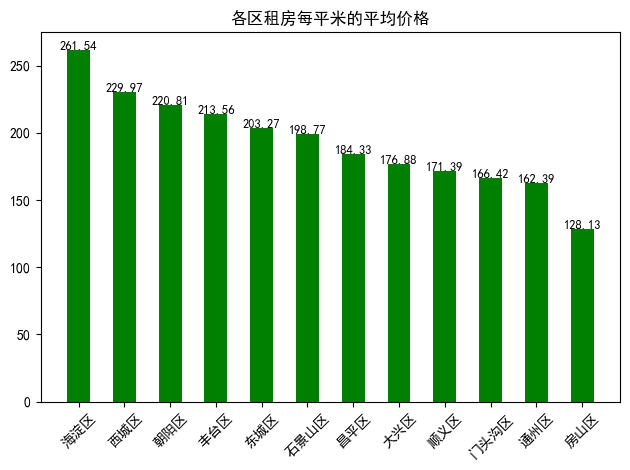

In [80]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 

result = data.groupby('位置1').agg({'房子每平方的价格':'mean'}).sort_values(['房子每平方的价格'],ascending = False)
# print(result)

fig,ax = plt.subplots(tight_layout = True)
plt.bar(result.index,height=result.values.flatten(),width=0.5,bottom=0,align='center',color='g',linewidth=2)
plt.title('各区租房每平米的平均价格')
ax.set_xticks(np.arange(result.shape[0]),labels = result.index,rotation = 45)
for x,y in zip(result.index,result.values.flatten()):
    plt.text(x,y,'%.2f'%y,ha='center',fontsize=9)
plt.tight_layout()
plt.savefig("./3_1_1.jpg")
plt.show()

### 3.1.2 各区老旧小区或小民房情况分析

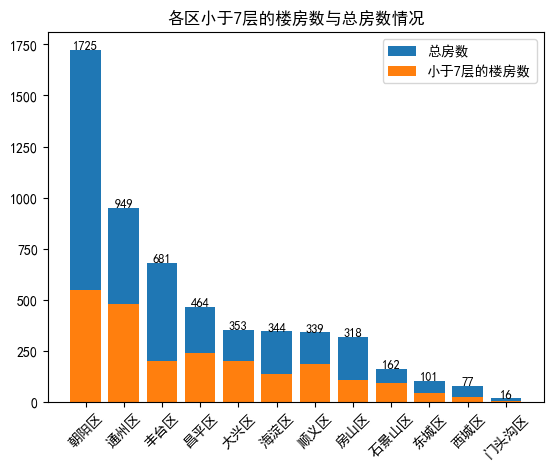

In [86]:
#每个区总楼层数小于7层的楼房数量
num_1to6 = data.groupby('位置1').apply(lambda x: (x['楼的总层数']<7).sum())
num_1to6 = pd.DataFrame(num_1to6,columns=['小于7层的楼房数量'])
#每个区的楼房数量
num_7 = data.groupby('位置1').agg({'楼的总层数':'count'})
situation = pd.concat([num_1to6,num_7],join='inner',axis=1)
situation.loc[:,'小于7层的楼房数量占比'] = situation['小于7层的楼房数量']/situation['楼的总层数']
situation = situation.sort_values(by='小于7层的楼房数量占比')
situation = situation.sort_values(by='楼的总层数',ascending=False)
# situation.head()

plt.title('各区小于7层的楼房数与总房数情况')
plt.bar(situation.index,situation['楼的总层数'],align='center',label = '总房数')
plt.bar(situation.index,situation['小于7层的楼房数量'],label='小于7层的楼房数')
plt.xticks(np.arange(situation.shape[0]),situation.index,rotation = 45)
plt.legend()
for x,y in zip(situation.index,situation['楼的总层数'].values.flatten()):
    plt.text(x,y,'%d'%y,ha='center',fontsize=9)
plt.savefig("./3_1_2.jpg")
plt.show()

### 3.1.3 各区房子价格与地铁站距离、户型类别的关系分析

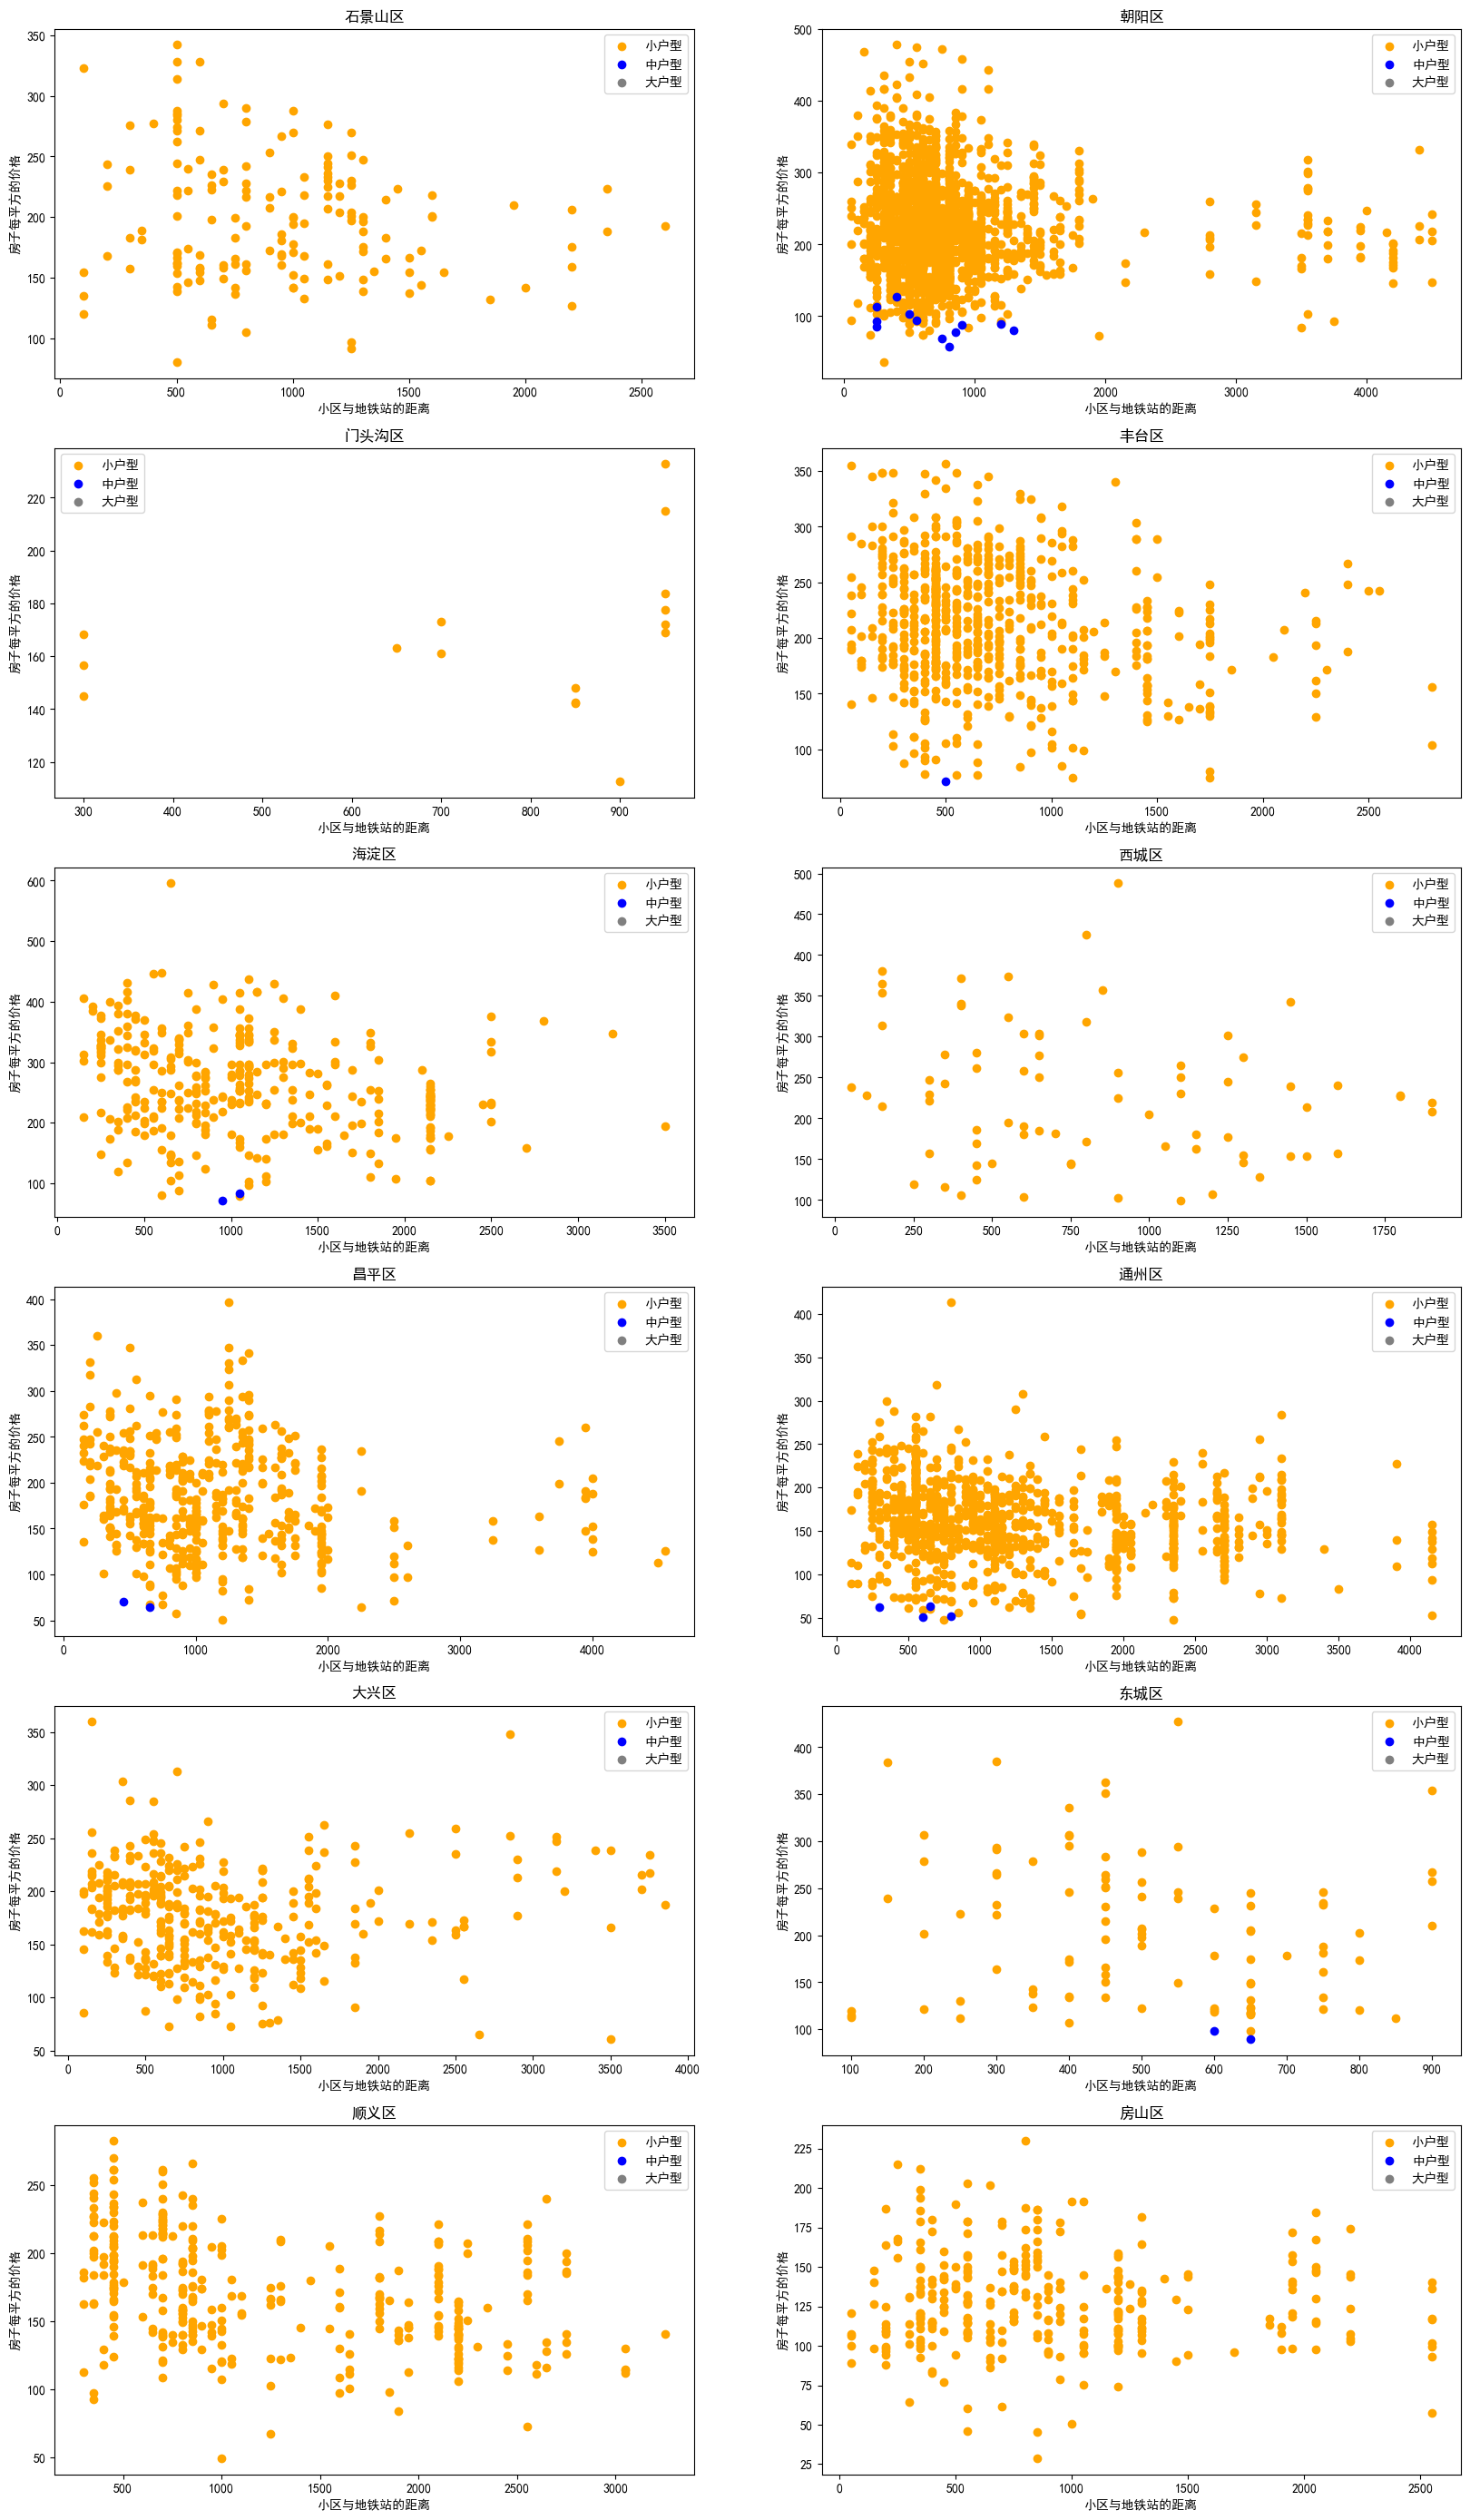

In [79]:
#面积小于90平方为小户型；面积大于等于90且小于144平方为中户型；面积大于等于144为大户型
data.loc[:,'户型类别'] = data['面积'].apply(lambda x: '小户型'if x<90 else('中户型' if x<144  else '大户型'))
partition = list(set(data['位置1']))
# print(len(partition))
fig,axes = plt.subplots(int(np.ceil(len(partition))/2),2,figsize=(20,35))
for index,place in enumerate(partition):
    ax = axes[index//2,index%2]
    ax.set_title(place)
    ax.scatter(data[(data.loc[:,'位置1']==place)&(data.loc[:,'户型类别']=='小户型')]['小区与地铁站的距离'].values,data[(data.loc[:,'位置1']==place)&(data.loc[:,'户型类别']=='小户型')]['房子每平方的价格'].values,c='orange',label='小户型')
    ax.scatter(data[(data.loc[:,'位置1']==place)&(data.loc[:,'户型类别']=='中户型')]['小区与地铁站的距离'].values,data[(data.loc[:,'位置1']==place)&(data.loc[:,'户型类别']=='中户型')]['房子每平方的价格'].values,c='blue',label='中户型')
    ax.scatter(data[(data.loc[:,'位置1']==place)&(data.loc[:,'户型类别']=='大户型')]['小区与地铁站的距离'].values,data[(data.loc[:,'位置1']==place)&(data.loc[:,'户型类别']=='大户型')]['房子每平方的价格'].values,c='gray',label='大户型')
    ax.set_xlabel('小区与地铁站的距离')
    ax.set_ylabel('房子每平方的价格')
    ax.legend()
plt.savefig("./3_1_3.jpg")
plt.show()

## 3.2 地理环境分析

### 3.2.1 房子所在楼层与价格的关系分析

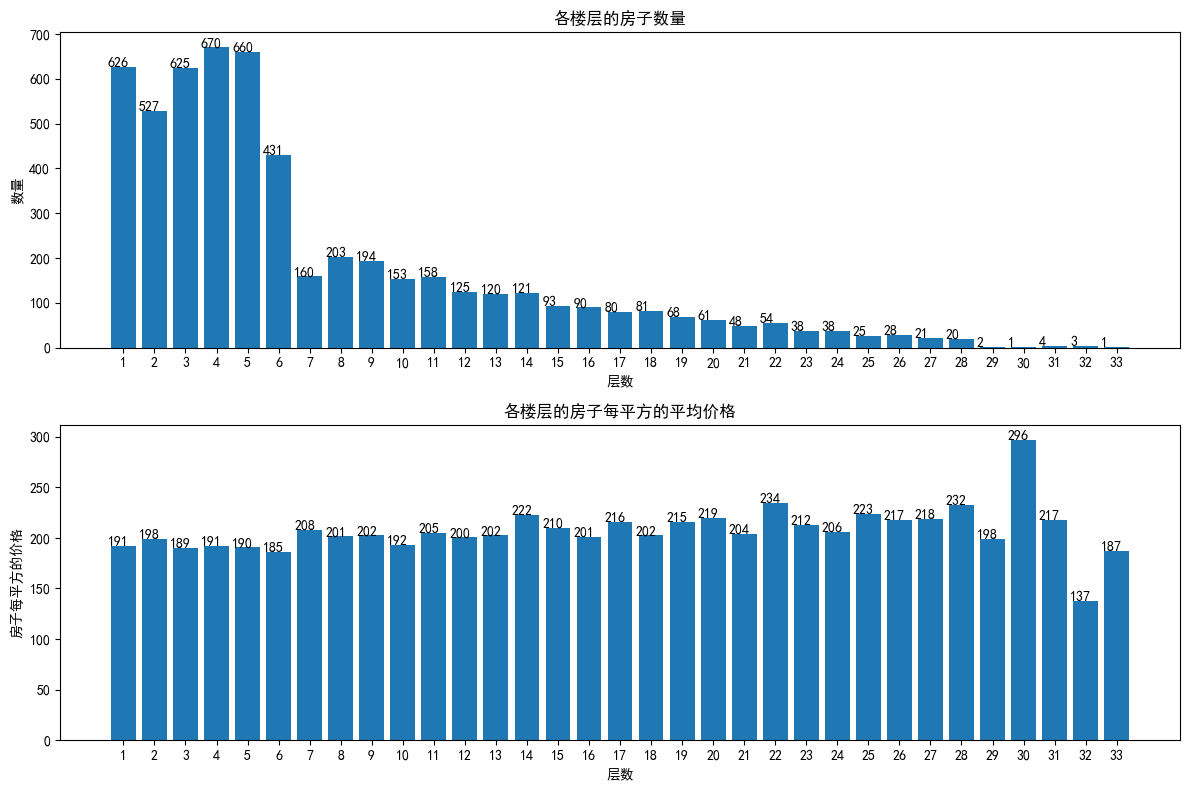

In [81]:
#各楼层的房子数量
res = data.groupby(['所在楼层']).agg({'楼层':'count'})
fig,axes = plt.subplots(2,1,figsize=(12,8))
ax = axes[0]
ax.set_title('各楼层的房子数量')
ax.bar(res.index,res['楼层'].values)
ax.set_xticks(np.arange(1,res.shape[0]+1))
ax.set_xlabel('层数')
ax.set_ylabel('数量')
for x,y in zip(res.index,res['楼层'].values):
    ax.text(x-0.5,y,'%d'%y)

#各楼层的房子每平方的平均价格
res = data.groupby(['所在楼层']).agg({'房子每平方的价格':'mean'})
ax = axes[1]
ax.set_title('各楼层的房子每平方的平均价格')
ax.bar(res.index,res['房子每平方的价格'].values)
ax.set_xticks(np.arange(1,res.shape[0]+1))
ax.set_xlabel('层数')
ax.set_ylabel('房子每平方的价格')
for x,y in zip(res.index,res['房子每平方的价格'].values):
    ax.text(x-0.5,y,'%d'%y)
plt.tight_layout()
plt.savefig("./3_2_1.jpg")
plt.show()

### 3.2.2 各区房子价格与地铁站距离、有无电梯的关系分析

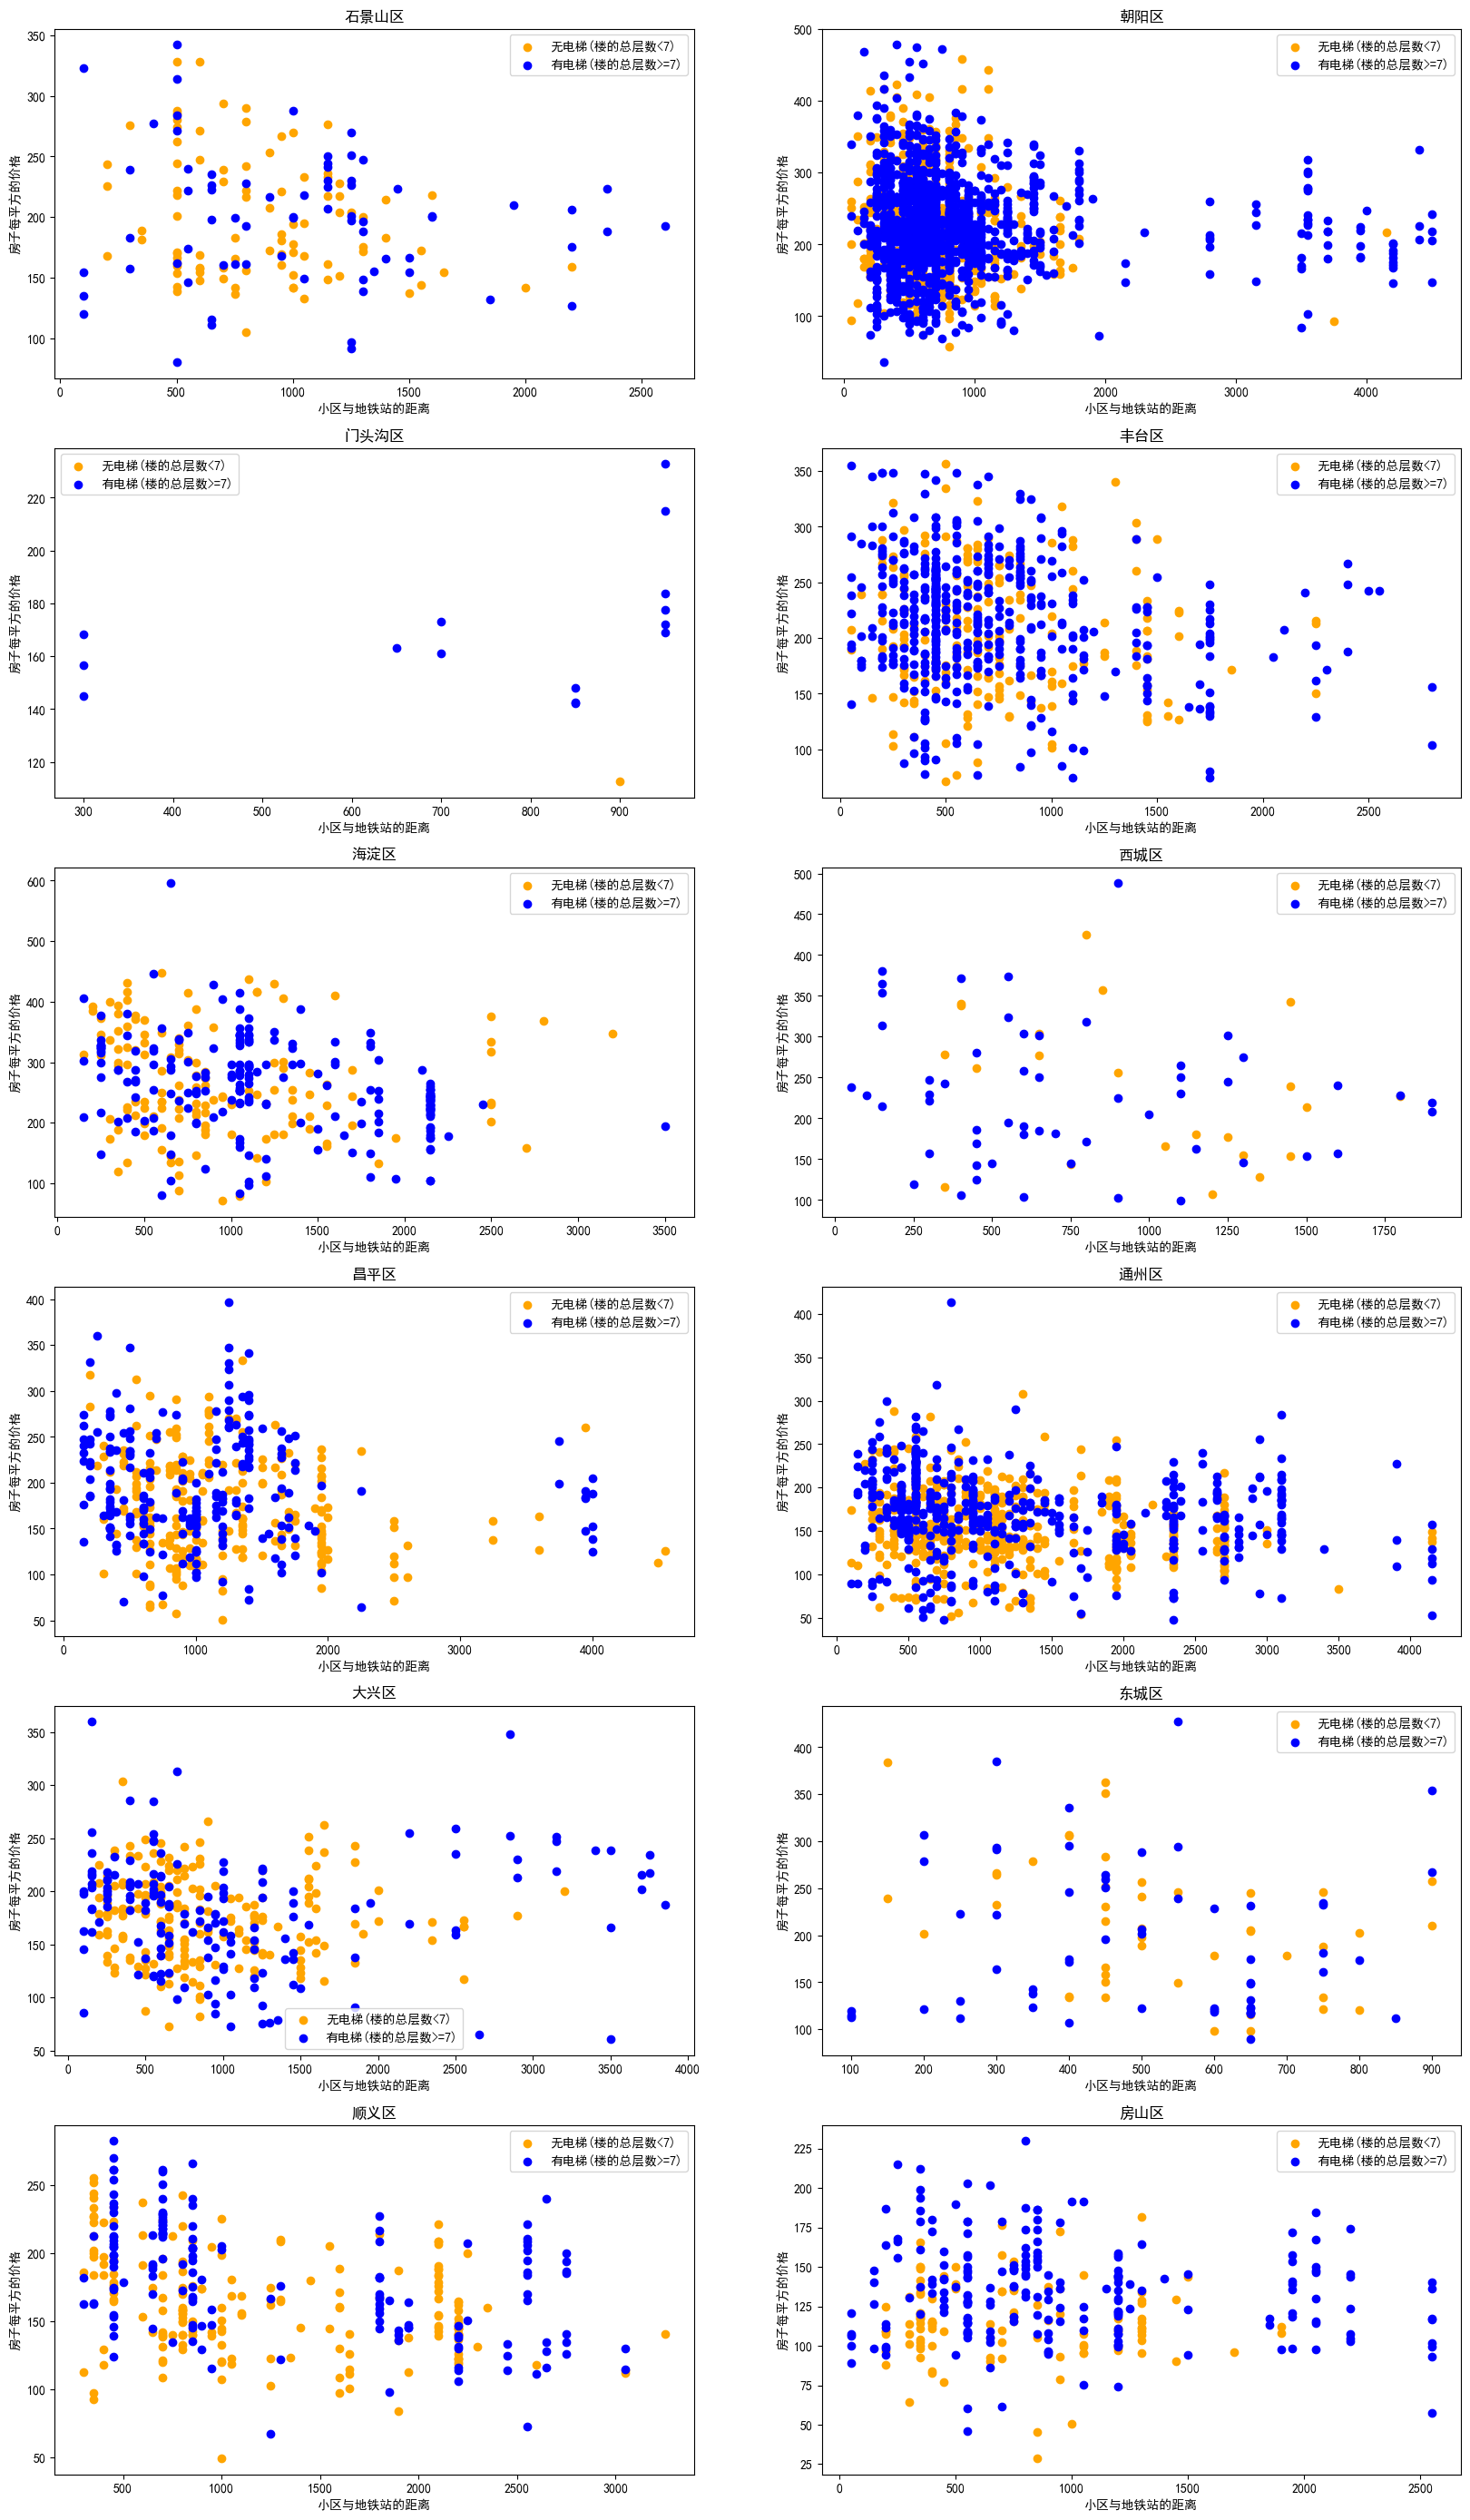

In [82]:
#默认楼层小于7的楼房为老旧小区或小民房，无电梯设施（不考虑老旧小区改造情况）
#获取各房子每平方的价格
partition = list(set(data['位置1']))
# print(partition)
fig,axes = plt.subplots(int(np.ceil(len(partition))/2),2,figsize=(20,35))
for index,place in enumerate(partition):
    ax = axes[index//2,index%2]
    ax.set_title(place)
    ax.scatter(data[(data.loc[:,'位置1']==place)&(data.loc[:,'楼的总层数']<7)]['小区与地铁站的距离'].values,data[(data.loc[:,'位置1']==place)&(data.loc[:,'楼的总层数']<7)]['房子每平方的价格'].values,c='orange',label='无电梯(楼的总层数<7)')
    ax.scatter(data[(data.loc[:,'位置1']==place)&(data.loc[:,'楼的总层数']>=7)]['小区与地铁站的距离'].values,data[(data.loc[:,'位置1']==place)&(data.loc[:,'楼的总层数']>=7)]['房子每平方的价格'].values,c='blue',label='有电梯(楼的总层数>=7)') 
    ax.set_xlabel('小区与地铁站的距离')
    ax.set_ylabel('房子每平方的价格')
    ax.legend()
plt.savefig("./3_2_2.jpg")
plt.show()